In [1]:
from jax import random, numpy as jnp
from stadion.models import LinearSDE, MLPSDE
from pprint import pprint
from stadion import kds_loss
from scipy.linalg import solve_continuous_lyapunov
import numpy as onp
import ot

2025-01-25 10:45:01.217910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-25 10:45:01.228177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-25 10:45:01.231323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 10:45:01.799481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from nn import NNSDE

In [3]:
n = 10000
d = 2
r = 2
n_envs = 2
epsilon = 2.0
gamma = 0.98
activation = "linear"

n_samples_burnin=200

In [4]:
key = random.PRNGKey(10)
true_model = NNSDE(
    hidden_size = r, 
    activation=activation,
    epsilon = epsilon,
    gamma = gamma,
    sde_kwargs = {"n_samples_burnin": n_samples_burnin})
true_model.n_vars = d

key, subk = random.split(key)
param = true_model.init_param(subk, d, scale=1.0)
true_model.param = param

In [5]:
#One-hot learned intervention mode
targets = [jnp.zeros(d)]
for k in range(n_envs-1):
    target = jnp.array([0] * d)
    target = target.at[k].add(1)
    targets.append(target)

key, subk = random.split(key)
train_intv_param = true_model.init_intv_param(subk, d = d, scale=1.0, n_envs = n_envs, targets = targets)

datasets = []
for k in range(n_envs):
    local_intv_param = train_intv_param.index_at(k)
    key, subk = random.split(key)
    data = true_model.sample(subk, n_samples = n, intv_param = local_intv_param)
    datasets.append(data)

In [6]:
activation="relu"

In [7]:
true_model = NNSDE(
    hidden_size = r, 
    activation=activation,
    epsilon = epsilon,
    gamma = gamma,
    sde_kwargs = {"n_samples_burnin": n_samples_burnin})
true_model.n_vars = d

key, subk = random.split(key)
param = true_model.init_param(subk, d, scale=1.0)
param["mlp_b_0"] *= 0
param["mlp_0"] = jnp.identity(d)
param["mlp_1"] = jnp.identity(d)
true_model.param = param

#One-hot learned intervention mode
targets = [jnp.zeros(d)]
for k in range(n_envs-1):
    target = jnp.array([0] * d)
    target = target.at[k].add(1)
    targets.append(target)

key, subk = random.split(key)
train_intv_param = true_model.init_intv_param(subk, d = d, scale=4.0, n_envs = n_envs, targets = targets)

hard_datasets = []
for k in range(n_envs):
    local_intv_param = train_intv_param.index_at(k)
    key, subk = random.split(key)
    data = true_model.sample(subk, n_samples = n, intv_param = local_intv_param)
    hard_datasets.append(data)

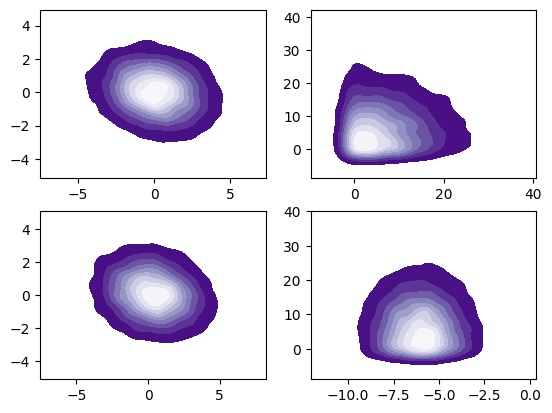

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

fig, axes = plt.subplots(nrows=2, ncols=2)


for i in range(2):
    x = datasets[i][:,0]
    y = datasets[i][:,1]
    # sns.set_style("white")
    sns.kdeplot(x=x, y=y, ax = axes[i,0], fill=True,cmap="Purples_r")
for i in range(2):
    x = hard_datasets[i][:,0]
    y = hard_datasets[i][:,1]
    sns.kdeplot(x=x, y=y, ax = axes[i,1], fill=True,cmap="Purples_r")
plt.savefig("example_contour.png")